In [7]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 107.1 MB/s eta 0:00:00


In [1]:
# 📘 05_docking_simulation.ipynb
# Step C: Protein-Ligand Docking using AutoDock Vina

# 🔲 Cell C1: Install AutoDock Vina and Open Babel
!apt-get install -y autodock-vina > /dev/null 2>&1
!apt-get install -y openbabel > /dev/null 2>&1

# Create required folders
import os
for folder in ["receptors", "ligands", "poses", "scores"]:
    os.makedirs(folder, exist_ok=True)
print("✅ Folders ready")


✅ Folders ready


In [28]:

# 🔲 Cell C2: Load input filenames
import glob
from Bio.PDB import PDBParser
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import warnings

# Silence Biopython warnings
warnings.simplefilter("ignore", PDBConstructionWarning)

# Helper: check if PDB file is valid and contains atoms
def is_valid_pdb(filepath):
    try:
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("struct", filepath)
        atoms = list(structure.get_atoms())
        return len(atoms) > 0
    except Exception as e:
        print(f"⚠️ {filepath} → INVALID PDB: {e}")
        return False

# Load ligand .pdbqt files
ligand_files = glob.glob("ligands/*.pdbqt")
ligand_files = [f for f in ligand_files if os.path.getsize(f) > 100]
print(f"✅ Found {len(ligand_files)} valid ligand(s): {[os.path.basename(f) for f in ligand_files]}")

# Load enzyme .pdb files
enzyme_pdbs = glob.glob("structures/*.pdb")
enzyme_pdbs = [f for f in enzyme_pdbs if is_valid_pdb(f)]
print(f"✅ Found {len(enzyme_pdbs)} valid enzyme(s): {[os.path.basename(f) for f in enzyme_pdbs]}")



✅ Found 3 valid ligand(s): ['alginate_dimer.pdbqt', 'cellobiose.pdbqt', 'xylobiose.pdbqt']
✅ Found 14 valid enzyme(s): ['GH48_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb', 'GH11_sample_2_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb', 'GH10_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb', 'GH5_sample_2_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb', 'PL7_sample_2_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb', 'PL1_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb', 'PL7_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb', 'GH11_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb', 'CE1_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb', 'PL1_sample_2_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb', 'GH5_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb', 'GH10_sample_2_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb', 'CE1_sample_2_unrelaxed

In [29]:
# 🔲 Cell C3: Convert enzyme PDB to PDBQT using Open Babel

# Convert validated enzymes from PDB to PDBQT using Open Babel
for pdb_path in enzyme_pdbs:
    name = os.path.splitext(os.path.basename(pdb_path))[0]
    pdbqt_path = f"receptors/{name}.pdbqt"

    if not os.path.exists(pdbqt_path) or os.path.getsize(pdbqt_path) < 100:
        conversion_cmd = f"obabel -ipdb {pdb_path} -O {pdbqt_path} -xh > /dev/null 2>&1"
        result = os.system(conversion_cmd)
        if os.path.exists(pdbqt_path) and os.path.getsize(pdbqt_path) > 100:
            print(f"✅ Converted {name} to PDBQT")
        else:
            print(f"⛔️ Failed to convert {name}")
    else:
        print(f"⏭️ Skipped {name} (already exists)")


✅ Converted GH48_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000 to PDBQT
✅ Converted GH11_sample_2_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000 to PDBQT
✅ Converted GH10_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000 to PDBQT
✅ Converted GH5_sample_2_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000 to PDBQT
✅ Converted PL7_sample_2_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000 to PDBQT
✅ Converted PL1_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000 to PDBQT
✅ Converted PL7_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000 to PDBQT
✅ Converted GH11_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000 to PDBQT
✅ Converted CE1_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000 to PDBQT
✅ Converted PL1_sample_2_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000 to PDBQT
✅ Converted GH5_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000 to PDBQT
✅ Converted GH10_sample_2_unrelaxed_rank_001_alphafold2_ptm_m

In [30]:
!rm -f poses/*.pdbqt poses/*.txt
print("🧼 Cleaned poses/ folder")


🧼 Cleaned poses/ folder


In [ ]:
# 🔲 Cell C4: Run AutoDock Vina docking

from Bio.PDB import PDBParser
import numpy as np

def get_center_from_pdb(pdb_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    atoms = list(structure.get_atoms())
    coords = np.array([atom.coord for atom in atoms])
    center = coords.mean(axis=0)
    return center[0], center[1], center[2]

results = []

for pdb_path in enzyme_pdbs:
    enzyme_name = os.path.splitext(os.path.basename(pdb_path))[0]
    receptor = f"receptors/{enzyme_name}.pdbqt"

    if not os.path.exists(receptor):
        print(f"⛔️ Missing receptor file for {enzyme_name}")
        continue

    try:
        cx, cy, cz = get_center_from_pdb(pdb_path)
    except Exception as e:
        print(f"❌ Failed to get center for {enzyme_name}: {e}")
        continue

    for ligand_path in ligand_files:
        ligand_name = os.path.splitext(os.path.basename(ligand_path))[0]
        out_pose = f"poses/{enzyme_name}__{ligand_name}.pdbqt"

        vina_cmd = (
            f"vina --receptor {receptor} --ligand {ligand_path} "
            f"--out {out_pose} "
            f"--center_x {cx:.2f} --center_y {cy:.2f} --center_z {cz:.2f} "
            f"--size_x 20 --size_y 20 --size_z 20 --num_modes 1 --exhaustiveness 8"
        )

        print(f"🧬 Docking: {enzyme_name} vs {ligand_name}")
        try:
            output = os.popen(vina_cmd).read()
        except Exception as e:
            print(f"❌ Exception running Vina: {e}")
            continue

        # Parse score directly from vina stdout
        score = None
        for line in output.splitlines():
            if line.strip().startswith("1"):
                try:
                    score = float(line.split()[1])
                except Exception as e:
                    print(f"❌ Score parse error: {e}")
                break

        results.append((enzyme_name, ligand_name, score))
        print(f"➡️ Score: {score}")



print("✅ All docking simulations completed")

In [40]:
# debugging cell 4

import os
from Bio.PDB import PDBParser
import numpy as np

# 🧬 Specify one pair for testing
enzyme_pdb = "structures/GH10_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb"
ligand_pdbqt = "ligands/cellobiose.pdbqt"
receptor_pdbqt = "receptors/GH10_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdbqt"
output_pose = "poses/GH10_cellobiose_test.pdbqt"


# 📍 Compute grid center from enzyme structure
def get_center_from_pdb(pdb_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    atoms = list(structure.get_atoms())
    coords = np.array([atom.coord for atom in atoms])
    center = coords.mean(axis=0)
    return center[0], center[1], center[2]

cx, cy, cz = get_center_from_pdb(enzyme_pdb)

# 🧪 Build docking command (larger grid size for better capture)
vina_cmd = (
    f"vina --receptor {receptor_pdbqt} --ligand {ligand_pdbqt} "
    f"--out {output_pose} "
    f"--center_x {cx:.2f} --center_y {cy:.2f} --center_z {cz:.2f} "
    f"--size_x 40 --size_y 40 --size_z 40 "
    f"--num_modes 1 --exhaustiveness 8"
)

# 🚀 Run and print Vina's full output
print(f"🧬 Docking: GH48 vs alginate_dimer")
print(f"📦 Command:\n{vina_cmd}")
print("\n📤 Output:\n" + "="*60)

output = os.popen(vina_cmd).read()
print(output)
print("="*60)

# 🔍 Try to extract score from output if available
score = None
for line in output.splitlines():
    if line.strip().startswith("1"):
        try:
            score = float(line.split()[1])
        except Exception as e:
            print(f"❌ Score parse error: {e}")
        break

print(f"✅ Final extracted score: {score}")



🧬 Docking: GH48 vs alginate_dimer
📦 Command:
vina --receptor receptors/GH10_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdbqt --ligand ligands/cellobiose.pdbqt --out poses/GH10_cellobiose_test.pdbqt --center_x 2.05 --center_y -2.28 --center_z -2.15 --size_x 40 --size_y 40 --size_z 40 --num_modes 1 --exhaustiveness 8

📤 Output:
AutoDock Vina v1.2.3
#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# J. Eberhardt, D. Santos-Martins, A. F. Tillack, and S. Forli  #
# AutoDock Vina 1.2.0: New Docking Methods, Expanded Force      #
# Field, and Python Bindings, J. Chem. Inf. Model. (2021)       #
# DOI 10.1021/acs.jcim.1c00203                                  #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and

In [35]:
! vina --receptor receptors/GH48_sample_1_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdbqt --ligand ligands/cellobiose.pdbqt --out poses/test_out.pdbqt --log poses/test_out.txt --center_x 1.56 --center_y -2.55 --center_z -1.28 --size_x 20 --size_y 20 --size_z 20



AutoDock Vina v1.2.3
Command line parse error: unrecognised option '--log'

Correct usage:

Input:
  --receptor arg             rigid part of the receptor (PDBQT)
  --flex arg                 flexible side chains, if any (PDBQT)
  --ligand arg               ligand (PDBQT)
  --batch arg                batch ligand (PDBQT)
  --scoring arg (=vina)      scoring function (ad4, vina or vinardo)

Search space (required):
  --maps arg                 affinity maps for the autodock4.2 (ad4) or vina 
                             scoring function
  --center_x arg             X coordinate of the center (Angstrom)
  --center_y arg             Y coordinate of the center (Angstrom)
  --center_z arg             Z coordinate of the center (Angstrom)
  --size_x arg               size in the X dimension (Angstrom)
  --size_y arg               size in the Y dimension (Angstrom)
  --size_z arg               size in the Z dimension (Angstrom)
  --autobox                  set maps dimensions based on input l

In [24]:
# 🔲 Cell C5: Save docking results
import pandas as pd

df = pd.DataFrame(results, columns=["Enzyme", "Ligand", "Score_kcal_mol"])
df.to_csv("scores/docking_results.csv", index=False)
print("✅ Saved docking results to scores/docking_results.csv")

# 🔲 Cell C6: Select best ligand per enzyme and save summary
top_hits = df.sort_values("Score_kcal_mol").groupby("Enzyme").head(2)
top_hits.to_csv("scores/top_docking_summary.csv", index=False)

print("✅ Saved top 2 ligands per enzyme to scores/top_docking_summary.csv")

✅ Saved docking results to scores/docking_results.csv
✅ Saved top 2 ligands per enzyme to scores/top_docking_summary.csv


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


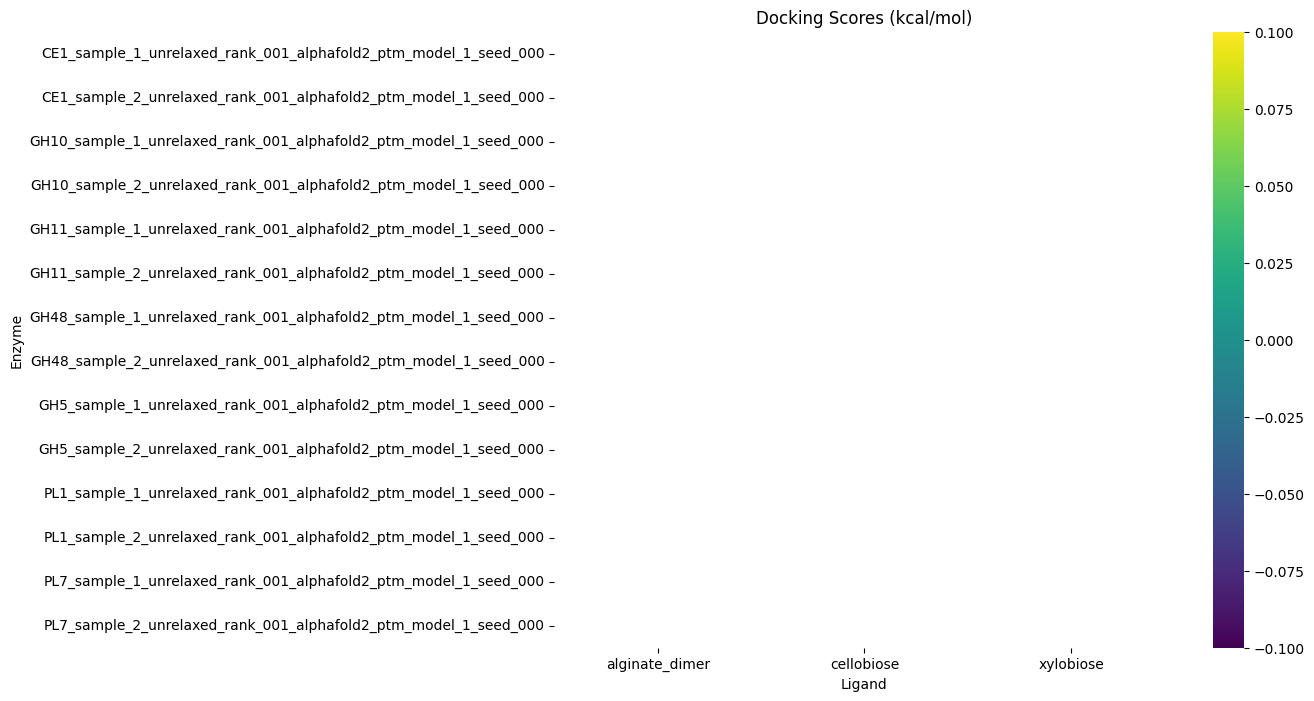

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the docking results
df = pd.read_csv("scores/docking_results.csv")

# Pivot the data to create a matrix for the heatmap
heatmap_data = df.pivot(index="Enzyme", columns="Ligand", values="Score_kcal_mol")

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".2f")
plt.title("Docking Scores (kcal/mol)")
plt.show()

In [22]:
results = []